# Inverse model on FetchNoTask

## Instanciate and train the model

Create the environment.

In [1]:
import gym
import panda_gym
from stable_baselines3.common.env_util import make_vec_env

env = make_vec_env("PandaNoTask-v0", env_kwargs=dict(nb_objects=1))

pybullet build time: May 20 2022 19:44:17


argv[0]=--background_color_red=0.8745098039215686
argv[1]=
argv[2]=
argv[3]=
argv[4]=
argv[5]=
argv[6]=
argv[7]=
argv[8]=
argv[9]=
argv[10]=
argv[11]=
argv[12]=
argv[13]=
argv[14]=
argv[15]=
argv[16]=
argv[17]=
argv[18]=
argv[19]=
argv[20]=
argv[21]=--background_color_green=0.21176470588235294
argv[22]=
argv[23]=
argv[24]=
argv[25]=
argv[26]=
argv[27]=
argv[28]=
argv[29]=
argv[30]=
argv[31]=
argv[32]=
argv[33]=
argv[34]=
argv[35]=
argv[36]=
argv[37]=
argv[38]=
argv[39]=
argv[40]=
argv[41]=
argv[42]=--background_color_blue=0.17647058823529413


Initilize the device.

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [3]:
import numpy as np
from stable_baselines3.common.buffers import ReplayBuffer

from copy import deepcopy


def collect_rollouts(n, env, replay_buffer):
    num_timesteps = 0
    last_obs = env.reset()

    while num_timesteps < n:
        # Select action randomly or according to policy
        action = np.array([env.action_space.sample()])

        # Rescale and perform action
        new_obs, rewards, dones, infos = env.step(action)

        num_timesteps += env.num_envs
        # Avoid modification by reference
        next_obs = deepcopy(new_obs)

        # As the VecEnv resets automatically, new_obs is already the
        # first observation of the next episode
        for i, done in enumerate(dones):
            if done and infos[i].get("terminal_observation") is not None:
                next_obs[i] = infos[i]["terminal_observation"]

        replay_buffer.add(
            last_obs,
            next_obs,
            action,
            rewards,
            dones,
            infos,
        )

        last_obs = new_obs


train_buffer = ReplayBuffer(
    50_000,
    env.observation_space,
    env.action_space,
    device=device,
)
test_buffer = ReplayBuffer(
    5_000,
    env.observation_space,
    env.action_space,
    device=device,
)

collect_rollouts(50_000, env, train_buffer)
collect_rollouts(5_000, env, test_buffer)

Instanciate the model and the optimizer.

In [4]:
from lge.forward_module import ForwardModule

from torch import optim

forward_module = ForwardModule(
    obs_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], latent_size=16
).to(device)
optimizer = optim.Adam(forward_module.parameters(), lr=1e-3, weight_decay=1e-5)

Train the model.

In [5]:
import torch.nn.functional as F


for epoch in range(3_000):
    # Sample
    sample = train_buffer.sample(128)
    observations = sample.observations.float()
    next_observations = sample.next_observations.float()
    actions = sample.actions

    # Compute the output image
    forward_module.train()
    pred_next_observation = forward_module(observations, actions)

    # Compute the loss
    loss = F.mse_loss(pred_next_observation, next_observations)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        sample = test_buffer.sample(128)
        observations = sample.observations.float()
        next_observations = sample.next_observations.float()
        actions = sample.actions

        # Compute the output image
        forward_module.eval()
        pred_next_observation = forward_module(observations, actions)
        # Compute the loss
        test_loss = F.mse_loss(pred_next_observation, next_observations)
        print("epoch: {:5d}\tprediction loss: train {:.5f}, test: {:.5f} ".format(epoch, loss.item(), test_loss.item()))

epoch:     0	prediction loss: train 0.36822, test: 0.34752 
epoch:   100	prediction loss: train 0.34099, test: 1.50629 
epoch:   200	prediction loss: train 0.42354, test: 0.16362 
epoch:   300	prediction loss: train 0.10280, test: 0.14746 
epoch:   400	prediction loss: train 1.42530, test: 0.28090 
epoch:   500	prediction loss: train 0.63747, test: 0.29658 
epoch:   600	prediction loss: train 0.77303, test: 0.60052 
epoch:   700	prediction loss: train 0.54372, test: 0.20699 
epoch:   800	prediction loss: train 0.32309, test: 0.11342 
epoch:   900	prediction loss: train 0.05732, test: 0.37693 
epoch:  1000	prediction loss: train 0.80530, test: 0.46523 
epoch:  1100	prediction loss: train 0.16026, test: 0.39332 
epoch:  1200	prediction loss: train 0.26740, test: 0.11484 
epoch:  1300	prediction loss: train 0.14969, test: 0.71759 
epoch:  1400	prediction loss: train 0.34662, test: 0.17267 
epoch:  1500	prediction loss: train 0.33708, test: 0.45887 
epoch:  1600	prediction loss: train 0.12

See the result for one transition.

In [8]:
# Sample one transition
sample = test_buffer.sample(1)
observations = sample.observations.float()
next_observations = sample.next_observations.float()
actions = sample.actions

# Predict the action
forward_module.eval()
pred_next_latent = forward_module(observations, actions)
next_latent = forward_module.encoder(next_observations)

# See the result
print("true latent\t\t", next_latent.squeeze().detach().cpu().numpy())
print("predicted latent\t", pred_next_latent.squeeze().detach().cpu().numpy())

true latent		 [ 0.1456874   0.05015915  0.21331604 -0.11159693 -0.05254291 -0.01742656
  0.33812153 -0.0670418  -0.11919834 -0.1422996   0.08832265 -0.14834379
  0.03850569 -0.09904759 -0.07290893 -0.21651375]
predicted latent	 [ 0.00284243 -0.01014193  0.05555608 -0.08629043 -0.5234257  -0.59389305
  0.02246137 -0.01211662  0.01474588  0.0254782  -0.0047803   0.05112509
  0.00233874 -0.00775038 -0.01152699 -0.01110311 -0.01256416  0.00378686
  0.10832126]


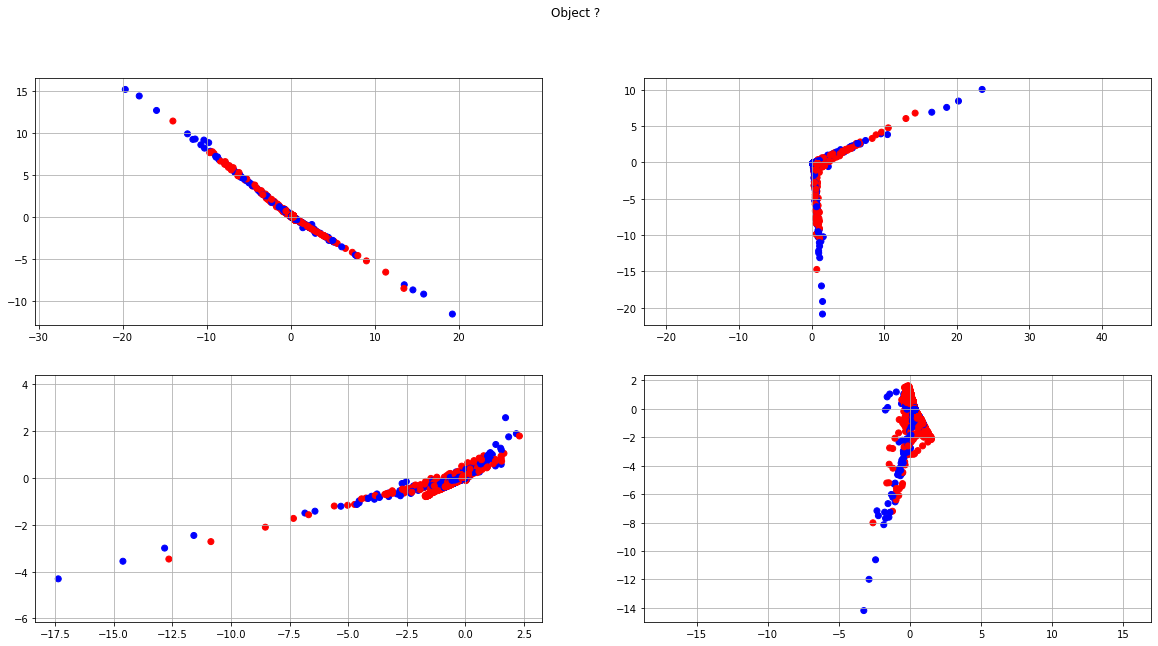

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(20)
title = "Object ?"
fig.suptitle(title)

observations = test_buffer.next_observations.squeeze(1)
embeddings = forward_module.encoder(train_buffer.to_torch(observations)).detach().cpu().numpy()
is_origin = np.linalg.norm(observations[..., 7:10] - np.array([0, 0, 0.02]), axis=1) < 0.1

color = list(np.where(is_origin, "b", "r"))
for i in range(2):
    for j in range(2):
        k = 2 * i + j
        axs[i, j].grid()
        axs[i, j].axis("equal")
        axs[i, j].scatter(*embeddings[:, 2 * k : 2 * k + 2].T, c=color)

# fig.savefig(title)